I used Colab to run the training on a GPU.

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#_ = !unzip 'drive/MyDrive/wild.zip'
#print('Complete')

Mounted at /content/drive
Complete


In [ ]:
#import sys
#sys.path.append('drive/MyDrive/SafariNet')

# Iteration 1

In [ ]:
from model import VGG16Counting
from utils import train

## Initial Training

In [ ]:
# Dataloaders
from dataset import ClassifyCountDataset
from torch.utils.data import DataLoader

train_dataset = ClassifyCountDataset(dataset_type='train', img_size=128, stdevs=True)
val_dataset = ClassifyCountDataset(dataset_type='val', img_size=128, stdevs=True)
nontest_dataset = ClassifyCountDataset(dataset_type='trainval', img_size=128, stdevs=True)
test_dataset = ClassifyCountDataset(dataset_type='test', img_size=128, stdevs=True)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
nontest_dataloader = DataLoader(nontest_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import numpy as np
import os

torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = VGG16Counting(num_classes=6, add_se=True).to(device)

save_path = 'drive/MyDrive/SafariNet/Iteration3'
os.makedirs(save_path, exist_ok = True)

In [ ]:
roc_aucs_by_epoch, mses_by_epoch = train(model3,
                                         train_dataloader,
                                         val_dataloader,
                                         save_path=save_path,
                                         ratio=10, stdevs=True)
np.save(save_path + '/aurocs.npy', roc_aucs_by_epoch)
np.save(save_path + '/mses.npy', mses_by_epoch)

Epoch: 1
Average precision by class: [0.715, 0.729, 0.983, 0.785, 0.657, 0.892]
Mean Relative Root Mean Squared Error: 0.4793
Epoch: 2
Average precision by class: [0.651, 0.755, 0.983, 0.795, 0.739, 0.951]
Mean Relative Root Mean Squared Error: 0.4588
Epoch: 3
Average precision by class: [0.887, 0.756, 0.989, 0.78, 0.588, 0.933]
Mean Relative Root Mean Squared Error: 0.4229
Epoch: 4
Average precision by class: [0.91, 0.821, 0.989, 0.879, 0.593, 0.954]
Mean Relative Root Mean Squared Error: 0.4553
Epoch: 5
Average precision by class: [0.692, 0.795, 0.984, 0.758, 0.841, 0.969]
Mean Relative Root Mean Squared Error: 0.4397
Epoch: 6
Average precision by class: [0.945, 0.753, 0.989, 1.0, 0.624, 0.979]
Mean Relative Root Mean Squared Error: 0.4271
Epoch: 7
Average precision by class: [0.845, 0.874, 0.995, 0.872, 0.605, 0.964]
Mean Relative Root Mean Squared Error: 0.4047
Epoch: 8
Average precision by class: [0.806, 0.811, 0.989, 0.821, 0.824, 0.995]
Mean Relative Root Mean Squared Error: 0.3

## Determining Optimal Epoch for Full Train-Validation Training

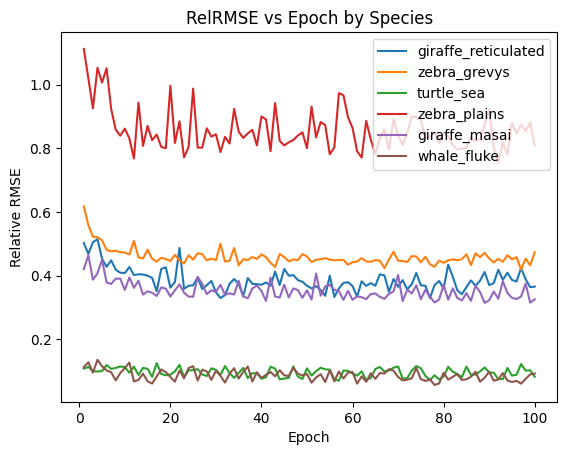

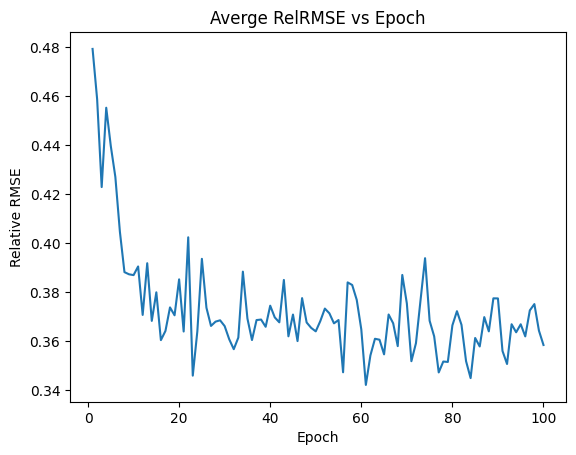

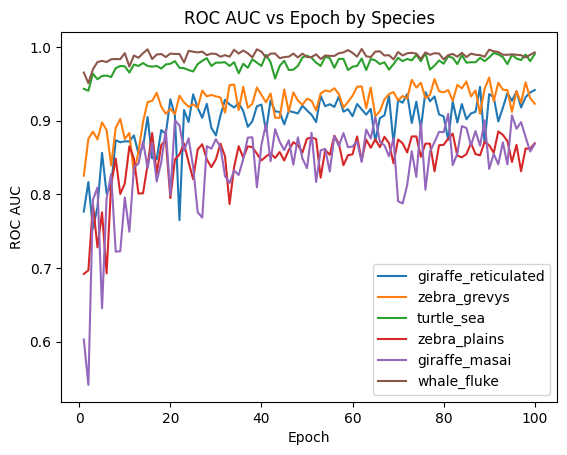

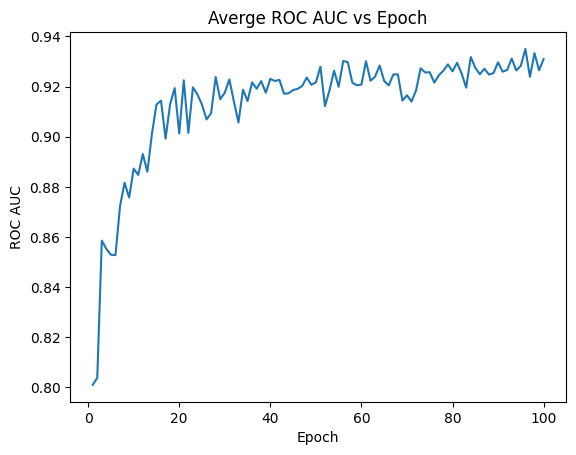

In [ ]:
from utils import epoch_graphs
epoch_graphs(roc_aucs_by_epoch, mses_by_epoch)

Average RelRMSE drops until about epoch 40 and then gently falls until around epoch 80, where it starts to become unstable. Average ROC AUC increases quickly until about epoch 20 and then slowly increases until around epoch 80. So, we chose 80 for the number of epochs to train our champion model.

## Training on Full Train-Val Dataset

In [ ]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bestmodel3 = VGG16Counting(num_classes=6, add_se=True).to(device)

In [ ]:
champ_num_epochs = 80
save_path = 'drive/MyDrive/SafariNet/Iteration3Test'
os.makedirs(save_path, exist_ok = True)
roc_aucs_on_test, relrmses_on_test = train(bestmodel3,
                                           nontest_dataloader,
                                           test_dataloader,
                                           num_epochs=champ_num_epochs,
                                           ratio=10, stdevs=True,
                                           save_path=save_path)


Epoch: 1
Average precision by class: [0.807, 0.73, 0.926, 0.657, 0.705, 0.91]
Mean Relative Root Mean Squared Error: 0.4576
Epoch: 2
Average precision by class: [0.782, 0.688, 0.973, 0.932, 0.688, 0.961]
Mean Relative Root Mean Squared Error: 0.4282
Epoch: 3
Average precision by class: [0.768, 0.853, 0.979, 0.719, 0.809, 0.939]
Mean Relative Root Mean Squared Error: 0.4326
Epoch: 4
Average precision by class: [0.78, 0.911, 0.979, 0.766, 0.797, 0.947]
Mean Relative Root Mean Squared Error: 0.422
Epoch: 5
Average precision by class: [0.943, 0.855, 0.989, 0.791, 0.639, 0.956]
Mean Relative Root Mean Squared Error: 0.417
Epoch: 6
Average precision by class: [0.91, 0.759, 0.99, 0.707, 0.768, 0.97]
Mean Relative Root Mean Squared Error: 0.4008
Epoch: 7
Average precision by class: [0.866, 0.913, 0.965, 0.793, 0.779, 0.984]
Mean Relative Root Mean Squared Error: 0.4083
Epoch: 8
Average precision by class: [0.909, 0.766, 0.985, 0.83, 0.785, 0.97]
Mean Relative Root Mean Squared Error: 0.3693
Ep

In [ ]:
from utils import display_results
# Displaying Test Scores
final_relrmses = relrmses_on_test[champ_num_epochs - 1, :]
final_roc_aucs = roc_aucs_on_test[champ_num_epochs - 1, :]
display_results(final_relrmses, final_roc_aucs)

RelRMSE = 0.27  &  AUROC = 0.93  <--  giraffe_reticulated
RelRMSE = 0.46  &  AUROC = 0.96  <--  zebra_grevys
RelRMSE = 0.05  &  AUROC = 0.99  <--  turtle_sea
RelRMSE = 0.73  &  AUROC = 0.85  <--  zebra_plains
RelRMSE = 0.4  &  AUROC = 0.87  <--  giraffe_masai
RelRMSE = 0.09  &  AUROC = 0.99  <--  whale_fluke
RelRMSE = 0.33  &  AUROC = 0.93  <--  average
